<a href="https://colab.research.google.com/github/SchmetterlingIII/D.T./blob/main/Bracing%20Concept/testing/spline_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%autosave 60

Autosaving every 60 seconds


# Spline Interpretation
The function of this .ipynb file is to:

    a. Interpret the curvature of a 2D spline
    b. Do the same with a 3D spline
    c. Do the same with the sensor data (and from now on, only testing with real data rather than abstracted forms as I am nearing the deadline)

### 2D Spline Interpretation

```
a. Plot these lines & interplolations
b. For each segment, get the second derivative and plot them dynamically
```

In [ ]:
import ipywidgets as ipy
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [ ]:
def spline_function(x=1):
    fig, ax = plt.subplots(figsize=(5,5))

    x_list = [-10, 0, x]
    eps = 0.01 # small value so that points aren't stacked on top of each other

    # strictly increasing list
    inc_x_list = []
    for i, val in enumerate(x_list):
        if i == 0:
            inc_x_list.append(val)
        else:
            # make sure each value larger than previous
            inc_x_list.append(max(val, inc_x_list[-1] + eps))

    xs = np.array(inc_x_list)
    ys = np.array([0, 50, 100])

    # I cannot interpret the derivatives of clamped cubic splines
    cs = CubicSpline(xs, ys, bc_type='natural')
    coeffs = []
    for i in range(2):
        for j in range(4):
            coeffs.append(cs.c[j,i])
    # coeffs 0 - 3 are for first segment; 4-7 for second
    display(Math(f"f(x) = {coeffs[0]:.5f}(x + {-1 * xs[0]})^3"))
    print(coeffs)
    print(x_list)

    x_plot = np.linspace(xs[0], xs[-1], 100)

    # plots of f(x), f'(x) and f''(x)
    ax.plot(x_plot, cs(x_plot), alpha=0.8, label='f(x)')
    ax.plot(x_plot, cs(x_plot, 1), label = "f'(x)")
    ax.plot(x_plot, cs(x_plot, 2), label = 'f''(x)')
    ax.scatter(xs, ys, color='k')

    """
    if the gradient of the second derivative is greater than three
    i.e. if the third derivative is greater than three
    """
    second_deriv_linear_coeff = coeffs[0] * 6 # gradient of second derivative of first segment
    if second_deriv_linear_coeff > 3:
        ax.clear()
        # plots of f(x), f'(x) and f''(x)
        ax.plot(x_plot, cs(x_plot), color='k', alpha=1, label='f(x)')
        ax.plot(x_plot, cs(x_plot, 1), label = "f'(x)")
        ax.plot(x_plot, cs(x_plot, 2), label = 'f''(x)')
        ax.scatter(xs, ys, color='k')
        print("Threshold has been exceeded.\nPlot not being displayed.")


    # setup
    ax.grid(alpha=0.25)
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(-5, 105)

    plt.show()

In [ ]:
ipy.interact(spline_function, x=(0, 10, 0.05))

### Sensor Test
**Deadline: Tomorrow**

Here I will be using the input of the sensor accelerometer data and doing a similar test: first interpolating using a cubic spline and then reading the second derivative in real time.

This can only be done in Thonny so the results of this are to be recorded on my phone.

**Intended Outcome**:
```
1. Live (noisy) sensor data displayed as vectors, using measured positions as inputs (and designing an algorithm to properly handle that)
2. Cubic spline interpolation of this -- still live and handled well
3. Second derivative display of this data, using feedback from how much I have curved the magnetic sheet to define the thresholds for each area.
4. Some output change (flashing lights on the Arduino) when the threshold has been exceeded
```

**Extension:**
```
- Cleaning up noisy sensor data (or displaying this accumulated noise in a graph).
- Seeing how the spine curves naturally (on the sagittal plane) and getting better results through numerical methods (seeing recordings of people moving their spine or something).
    - This can be developed by me using the IMUs as the beginning for good data collection on this. Therefore, if researchers were then to move on the graphene tubes that I am to research, they would have a good baseline to work from.

```

# Sensor Tasks
*These are slightly more formalised tasks*

**Task 1**: To transform raw serial data from multiple IMUs into a live, 3D representation of their positions in space.

**Task 2**: Plot these as cubic splines (rather than linear interpolation)

**Task 3**:
- Curvature: use the second derivative of the splines (reading each of the pieces in the colleciton.deque)

- Thresholds:
    - Small issue: each of the thresholds should respond to the parametrised second derivatives. Would I use the mean of these x,y,z derivates and develop a threshold around this?
    - Have to learn and use the curvature thing so once I get the cubic spline done, I will do that

    ```
    for segment in segments:
        if segment_curvature > threshold:
            set timer # using the python timer thing
            if timer > threshold_time:
                arduino_output
                colour_change # for the graph

    ```
    ***The success of this section is purely theoretical (since I can't get the sensors to hold still & there exists only one support), so hope that is robust enough (include my intuitions, maths and etc in writing) and then move onto designing the pieces that can be used for this test.**
- `arduino_output`: sending a command through the serial to the Arduino to change the frequency of the flashing lights


**EXTENSION**:
- math_exchange on understanding *true curvature* -- https://math.stackexchange.com/questions/1457699/easy-derivation-to-show-that-the-curvature-is-kt-frac-alpha-wedge-alpha

- planning how to test this properly at school (and what is left before only doing the aesthetics)
- displaying how noisy the data is and trying to clean it up (having a buffer period for ths):
    - this can be something I write about and explain but never apply since aesthetics and a lo-fi model is more important
- getting this basic script sent off to surgeons en-masse for feedback on how to interpret sections further (and just asking for advice)


In [ ]:
a = [8, 5]
b = [9, 1]

j = [len(i) for i in (a, b)]

if (max(j) - min(j)) == 0:
    print(a)

[8, 5]


In [ ]:
import serial.tools.list_ports
import string
import serial
import traceback ## my code is buggy and I would like to debug it
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import time
from collections import deque
import numpy as np

# reading the serial data
BAUDRATE = 115200
try:
    # setup for port communication
    ports = serial.tools.list_ports.comports()
    serialInst = serial.Serial()
    portList = [str(i) for i in ports]
    print(portList)

    com = input("Select COM PORT for Arduino: ")

    for i in range(len(portList)):
        if portList[i].startswith("COM" + str(com)):
            SERIAL_PORT = "COM" + str(com)
            print(SERIAL_PORT)

    serialInst.baudrate = BAUDRATE
    serialInst.port = SERIAL_PORT
    serialInst.open()
    print(f"Connected to {SERIAL_PORT} at {BAUDRATE} baud.")

    ## initial setup: 'begin program'
    while True:
        line = serialInst.readline().decode('utf-8') #.strip()
        if line: # if there is data in the readline
            print(f"Arduino: {line}")
        if "Number of sensors: " in line:
           ID_NUM = int(line.strip(":")[-3]) # the number of read sensors
           #print(ID_NUM)
           IMU_DEQUES = [deque(maxlen=50) for i in range(ID_NUM)]
        if "Waiting for 'begin program' command" in line:
            break

    # get the linear distances for the forward kinematics calculation
    print("INSTRUCTIONS:\nInput the linear distances between your sensors in metres.\nMeasure from lowest to highest.\nI would recommend using a high resolution ruler to reduce drift.\n")
    linear_distances = []
    for i in range(ID_NUM - 1):
        value = float(input(f"{i + 1}: "))
        linear_distances.append(value)

    print("Sending 'begin' command to Arduino")
    serialInst.write(b'begin program') # sent in bytes rather than high level strings
                                       # since it is sent to the compiler

    time.sleep(2)

    ###############################################
    """             Data Handling               """
    ###############################################

    # plot setup
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ## set the points for the animate(i) function
    ## these variables are what are updated (and saves clearing the plot each time)
    scatter = ax.scatter([], [], [], s=50)
    line, = ax.plot([], [], [])

    ax.set_title("IMU Positions")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")


    # SCALE BY THE LINEAR DISTANCES BETWEEN THE SENSORS
    ### DEFINE FORWARD KINEMATICS FUNCTION
    ### MORE EFFICIENT THAN INITIAL
    ### O(N) << O(N^2)
    def forward_kinematics(matrix):
        # Start with the position of the first sensor (the base)
        if not matrix:
            return []
        positions = [np.array(matrix[0])]
        t_value_distance = [0]
        cumulative_distance = 0

        for i in range(1, len(matrix)):
            direction_vector = np.array(matrix[i]/np.linalg.norm(matrix[i]))
            distance = linear_distances[i-1]
            link_vector = direction_vector * distance
            new_pos = positions[i-1] + link_vector
            positions.append(new_pos)

            cumulative_distance += distance
            t_value_distance.append(cumulative_distance)

        return positions, t_value_distance

    ###############################################
    """             Data Plotting               """
    ###############################################

    # the animate function embeds all
    # otherwise more jagged plotting will take place
    def animate(i):
        try:
            IMU_FULL_CHANNEL_DATA = serialInst.readline().decode('utf-8').strip().split(",")
            IMU_ID = int(IMU_FULL_CHANNEL_DATA[-1])
            IMU_DATA = [float(acc) for acc in IMU_FULL_CHANNEL_DATA[:3]] # ONLY APPENDING ACCELERATION, TO CHANGE WHEN DOING KALMAN FILTERING
            IMU_DATA_NORM = IMU_DATA/np.linalg.norm(IMU_DATA)


            if IMU_ID == 1:
                IMU_DEQUES[0].append(IMU_DATA_NORM)

            elif IMU_ID == 2:
                IMU_DEQUES[1].append(IMU_DATA_NORM)

            elif IMU_ID == 7:
                IMU_DEQUES[2].append(IMU_DATA_NORM)

            else:
                print(f"Warning: Recieved data from unknown data channel @ {IMU_ID}")

            if all(IMU_DEQUES):
                IMU_NORMALISED_MATRIX = [dque[-1] for dque in IMU_DEQUES]
                IMU_POSITIONS = np.array(forward_kinematics(IMU_NORMALISED_MATRIX)[0])

                ## update stored variables ("scatter" + "line,") with new positions
                ## more efficient than ax.clear()

                scatter._offsets3d = (IMU_POSITIONS[:, 0], IMU_POSITIONS[:, 1], IMU_POSITIONS[:, 2]) # plots all x, y, z coordinates: regardless of number of rows in this matrix
                line.set_data(IMU_POSITIONS[:, :2].T) # takes in (x,y) values of the points (matplotlib used to only do 2D stuff)
                line.set_3d_properties(IMU_POSITIONS[:, 2]) # add the z-coordinate (3D space) on top of this

                x = IMU_POSITIONS[:, 0]
                y = IMU_POSITIONS[:, 1]
                z = IMU_POSITIONS[:, 2]
                t_values = forward_kinematics(IMU_NORMALISED_MATRIX)[1]
                print(t_values)

                ax.set_xlim(left=min(x) + 0.1, right=max(x)+ 0.1)
                ax.set_ylim(bottom=min(y) + 0.1, top=max(y) + 0.1)
                ax.set_zlim(bottom=min(z) + 0.1, top=max(z) + 0.1)

        except (ValueError, IndexError) as e:
            print(f"Serial line error: {e}")
            print(f"{str(traceback.print_exc())}")
            pass

        return scatter, line,

    # PLOTTING DISPLAY
    anim = FuncAnimation(fig, animate, cache_frame_data=False, interval=200, blit=True) # blitting only draws the dynamic aspects of the plot
                                                                                        # rather than redrawing e.g. '{Title}' at each timestep
                                                                                        # this save computation

    ax.set_proj_type('ortho')
    plt.show()

except Exception as e:
    print(f"ERROR: {e}")

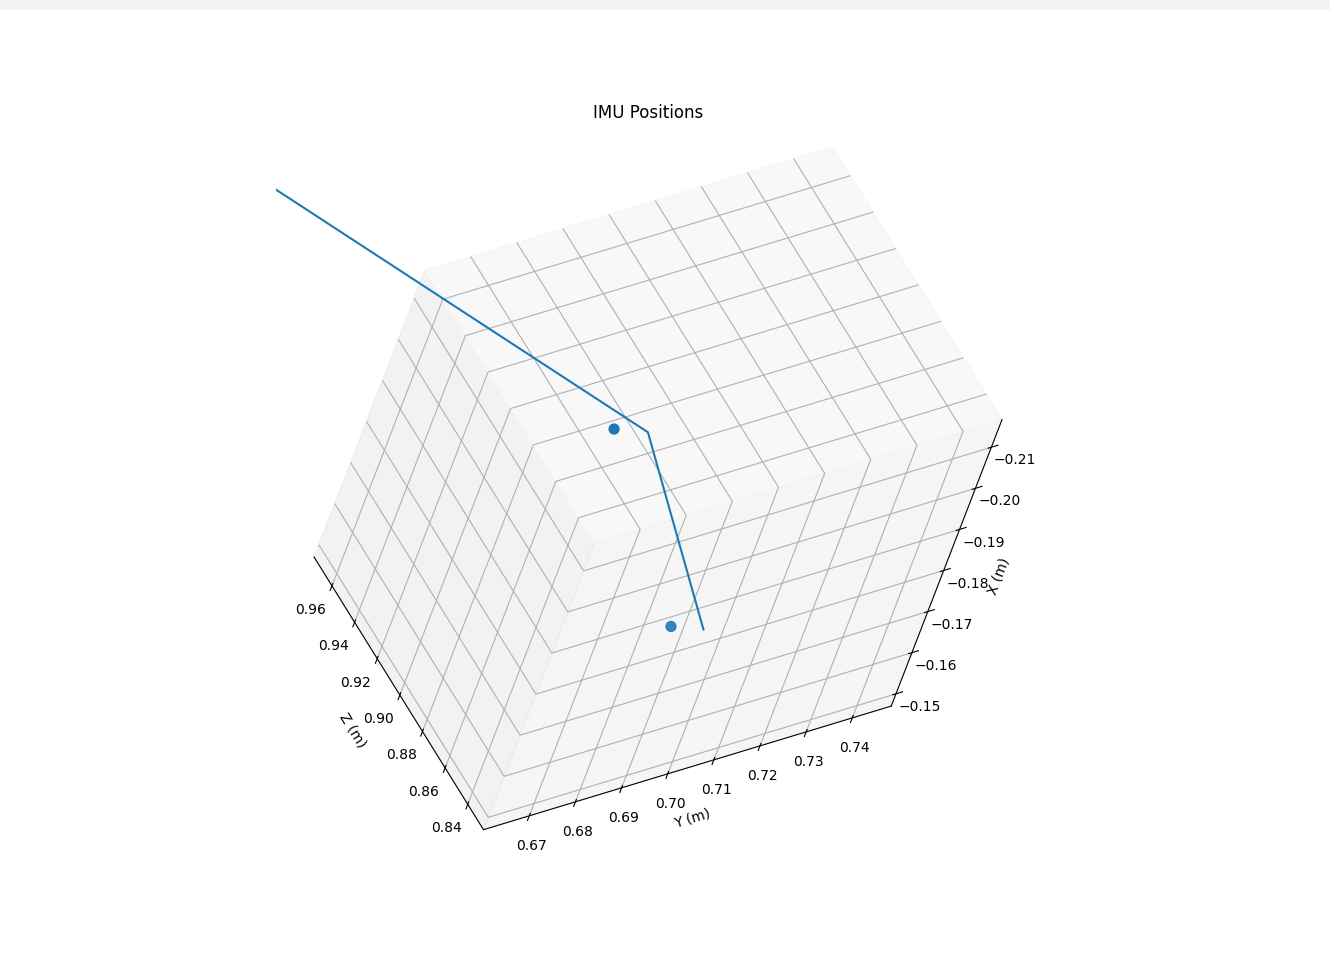

**Above**: When running the code (with the limits of sensors set) it tend to produce this weird thing which is pretty unhelpful. Not sure how I am meant to debug this as well but will move onto CubicSpline stuff until then

In [ ]:
>>> %Run -c $EDITOR_CONTENT
['COM4 - USB Serial Device (COM4)']
Select COM PORT for Arduino: 4
COM4
Connected to COM4 at 115200 baud.
Arduino: Scanning for MPU6050 sensors...

Arduino: MPU6050 found on channel: 1

Arduino: MPU6050 found on channel: 2

Arduino: MPU6050 found on channel: 7

Arduino: Scan complete.

Arduino: Number of sensors: 3

Arduino: Waiting for 'begin program' command from Python...

INSTRUCTIONS:
Input the linear distances between your sensors in metres.
Measure from lowest to highest.
I would recommend using a high resolution ruler to reduce drift.

1: 0.8
2: 1.2
Sending 'begin' command to Arduino
[0, np.float64(1.7002608188978967), np.float64(2.3116596642251377)]
[0, np.float64(1.7002133388889717), np.float64(2.310336879220833)]
[0, np.float64(1.7012085380953463), np.float64(2.308722202272333)]
[0, np.float64(1.7012085380953463), np.float64(2.3078122623177437)]
[0, np.float64(1.700975555042097), np.float64(2.3067901580239405)]
[0, np.float64(1.701909188664967), np.float64(2.306863843345119)]
[0, np.float64(1.701909188664967), np.float64(2.3137630890144245)]
[0, np.float64(1.702833266797377), np.float64(2.3189506290049837)]
[0, np.float64(1.7022670545750367), np.float64(2.3189851094288194)]
[0, np.float64(1.7022670545750367), np.float64(2.3197120422813353)]
[0, np.float64(1.7018079144171796), np.float64(2.3162820432259226)]
[0, np.float64(1.7016693695090244), np.float64(2.3157243373491117)]
[0, np.float64(1.7016693695090244), np.float64(2.3078162928124573)]
[0, np.float64(1.7031701176773655), np.float64(2.310697561458317)]
[0, np.float64(1.7019280643226833), np.float64(2.3130991998450496)]
[0, np.float64(1.7019280643226833), np.float64(2.305268296448368)]
[0, np.float64(1.6982442680490895), np.float64(2.2956412728149207)]
[0, np.float64(1.6995619850557635), np.float64(2.2942051177066367)]
[0, np.float64(1.6995619850557635), np.float64(2.308272761960484)]
[0, np.float64(1.7013631971098364), np.float64(2.315276393314129)]
[0, np.float64(1.7012590350387387), np.float64(2.3144619450534734)]
[0, np.float64(1.7012590350387387), np.float64(2.309990439743061)]
[0, np.float64(1.7003392801521715), np.float64(2.306417449522973)]
[0, np.float64(1.700181486565279), np.float64(2.3083774509117894)]
[0, np.float64(1.700181486565279), np.float64(2.31805580077557)]
[0, np.float64(1.700090090869896), np.float64(2.3181018400501943)]
[0, np.float64(1.6995748638604637), np.float64(2.31665525623587)]
[0, np.float64(1.6995748638604637), np.float64(2.3068718581907244)]
[0, np.float64(1.700541928498939), np.float64(2.3088376953349776)]
[0, np.float64(1.7010307947650332), np.float64(2.3088331324525146)]
[0, np.float64(1.7010307947650332), np.float64(2.313279418420447)]
[0, np.float64(1.7017253367062817), np.float64(2.315697715965786)]
[0, np.float64(1.7032315301025813), np.float64(2.315692481754368)]
[0, np.float64(1.7032315301025813), np.float64(2.321673792137373)]
[0, np.float64(1.7046142484593476), np.float64(2.324019445729593)]
[0, np.float64(1.7027125342509335), np.float64(2.3251810408519766)]
[0, np.float64(1.7027125342509335), np.float64(2.304374193003093)]
[0, np.float64(1.6976924480732087), np.float64(2.291484471398044)]
[0, np.float64(1.69773470321328), np.float64(2.2897254671472433)]
[0, np.float64(1.69773470321328), np.float64(2.297543389797544)]
[0, np.float64(1.7000340992390177), np.float64(2.3046718639489603)]
[0, np.float64(1.7008479670077348), np.float64(2.3063677292940192)]
[0, np.float64(1.7008479670077348), np.float64(2.3095234318034144)]
[0, np.float64(1.7021149780064502), np.float64(2.311154797468209)]
[0, np.float64(1.701102990754899), np.float64(2.3097944940746196)]
[0, np.float64(1.701102990754899), np.float64(2.303884237533528)]
[0, np.float64(1.7005890703708832), np.float64(2.3030175851807)]
[0, np.float64(1.7010061665217378), np.float64(2.3031357329933293)]
[0, np.float64(1.7010061665217378), np.float64(2.3101561179804833)]
[0, np.float64(1.6991151509685518), np.float64(2.3063518797232567)]
[0, np.float64(1.6991208061394103), np.float64(2.305761581443791)]
[0, np.float64(1.6991208061394103), np.float64(2.297433219940695)]
[0, np.float64(1.6999222298830556), np.float64(2.300102736432799)]
[0, np.float64(1.70087860961743), np.float64(2.3018189045742217)]
[0, np.float64(1.70087860961743), np.float64(2.3059987411785454)]
[0, np.float64(1.699957599091164), np.float64(2.304180363482735)]
[0, np.float64(1.698605648331159), np.float64(2.304345601443344)]
[0, np.float64(1.698605648331159), np.float64(2.3107568337572704)]
[0, np.float64(1.7007320401912194), np.float64(2.3138670728742636)]
[0, np.float64(1.7007649037896928), np.float64(2.3130403268258273)]
[0, np.float64(1.7007649037896928), np.float64(2.3044703104956836)]
[0, np.float64(1.7003930641844198), np.float64(2.303367330841352)]
[0, np.float64(1.7013420100586318), np.float64(2.3032454264035036)]
[0, np.float64(1.7013420100586318), np.float64(2.304369305472821)]
[0, np.float64(1.7002908850836524), np.float64(2.3023336367857694)]
[0, np.float64(1.700131611508251), np.float64(2.3019850345122306)]
[0, np.float64(1.700131611508251), np.float64(2.3016486241475644)]
[0, np.float64(1.7002015769674175), np.float64(2.302406113744078)]
[0, np.float64(1.7013173853798462), np.float64(2.3026547916354394)]
[0, np.float64(1.7013173853798462), np.float64(2.3066929305117467)]
[0, np.float64(1.7020247920575777), np.float64(2.308667399416257)]
[0, np.float64(1.7002810645081592), np.float64(2.307420286937357)]
[0, np.float64(1.7002810645081592), np.float64(2.30575344175153)]

>>>


**Above**: Truncated version of the output, but the `t_values` does not equal `[0, linear_distances[0], (linear_distances[0] + linear_distances[1])]`. This is quite confusing and will require debugging before the application of cubic splines so that it will be functional

**Major Error**: The produced shape (from outputting the tests) doesn't actually look like how the sensors actually are and do not respond dynamically to movement. This is simply through observsation so could be a result of how it is showed in the display form of matplotlib but this may accumulate later.

The code is robustly written so there isn't an issue in changing it -- it's just the vibe of how it is outputted (and my inability to visualise it well) that may cause this to be a 'major error'.

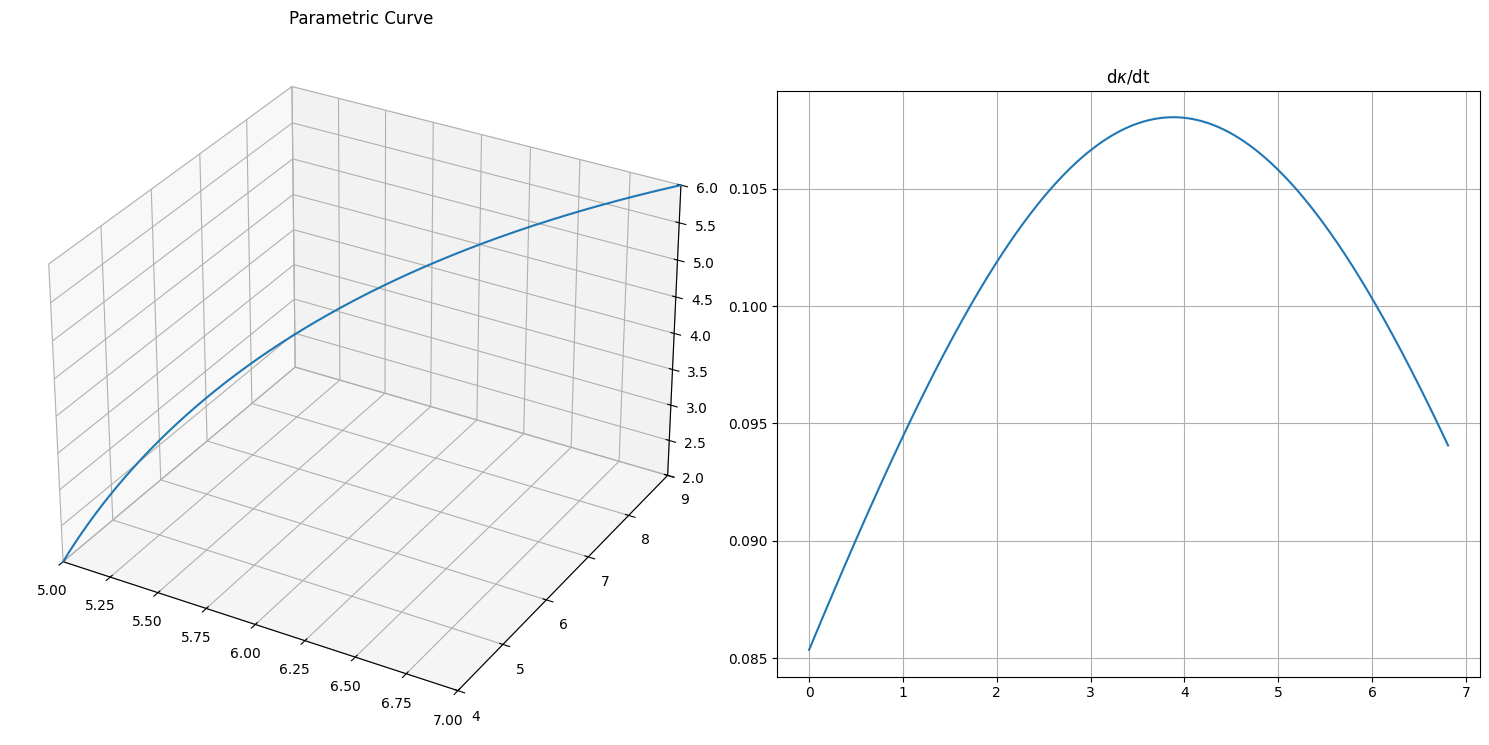

In [22]:
"""
Cubic spline test: here is a test for the cubic spline calculation since my previous endeavours were actually quite messy (and unhelpful).
I will now apply this to the IMU sensor test.
"""
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(15,8))
ax = fig.add_subplot(121, projection='3d')


a = (5,4,2)
b = (6,7,5)
c = (7,9,6)
array = np.array([np.array(i) for i in (a,b,c)])

t = [0]
c_dist = [0]
d_dist = 0
for i in range(len(array)):
    if i == len(array)-1:
        break

    distance = np.linalg.norm(array[i+1]-array[i])
    c_dist.append(distance)
    t.append(sum(c_dist))

x = array[:, 0]
y = array[:, 1]
z = array[:, 2]

xc = CubicSpline(t,x)
yc = CubicSpline(t,y)
zc = CubicSpline(t,z)

plotting_t = np.linspace(min(t), max(t), 1000)

ax.plot(xc(plotting_t), yc(plotting_t), zc(plotting_t))

ax.set_xlim(min(xc(plotting_t)), max(xc(plotting_t)))
ax.set_ylim(min(yc(plotting_t)), max(yc(plotting_t)))
ax.set_zlim(min(zc(plotting_t)), max(zc(plotting_t)))
ax.grid()

"""
Curvature Calculations
"""
curvature_list = []
for i in range(len(plotting_t)):
    r = (xc(plotting_t[i], 0), yc(plotting_t[i], 0), zc(plotting_t[i], 0))
    r_prime = (xc(plotting_t[i], 1), yc(plotting_t[i], 1), zc(plotting_t[i], 1))
    r_double_prime = (xc(plotting_t[i], 2), yc(plotting_t[i], 2), zc(plotting_t[i], 2))

    kappa = (np.linalg.norm(np.cross(r_prime, r_double_prime)))/(np.linalg.norm(r_prime)**3)
    curvature_list.append(kappa)

ax2 = fig.add_subplot(122)
ax2.plot(plotting_t, curvature_list)
ax2.grid()
ax2.set_aspect(250)

ax.set_title("Parametric Curve")
ax2.set_title(r"d$\kappa$/dt")

plt.tight_layout()
plt.show()

**Curvature Derivation & Practice Questions**:

I want to intuitively explain what this means (understanding helps with adding additional features) so I will copy up workings out into LaTeX, make apparent any errors in my process and then apply this to the IMU code as normal.

In this derivation, review circular motion and see how it relates to this (and do practice questions on it since my physics is worsening). Try out some PAT, TMUA and MAT papers.

Once this is done, the coded aspect of my project is entirely finished off!!

----------

**Curvature Application**: Here is how I would like to apply this (*eventually it will just be machine learning but we have not gotten there yet*):

- There will be a list of the instaneous curvatures along the spline
- There will be a storage of how those curvatures change wrt time
- There will be a maximum (that is tracked (and maybe marked with a red dot))
- There may be a measure of the standard deviation of points
- There may be an average (mean/median)

*For the initial application, I will be using max($\kappa$) as it is easiest (I hope) to get working. Then, I will try to develop a pseudocode and apply updates incrementally that works towards the main goal (as written below)*:

    
    When a user wears the posture bracing, there will be a calibration phase at the beginning where there is an implied best posture. They will then do a range of exercises that will help the model "understand" what the user's spine shape is. Then, the threshold is set on the deviance away from this ideal shape.

To scaffold onto this ideal, I think it will be best to go as follows:

1. max($\kappa$)
2. how $\kappa$ changes with time; larger differences indicates big curves (if the change results in a larger value -- *this will be difficult code to make robust so maybe this won't be second*)
3. integrating across the whole spine and then dividing by the change in bounds
    



**Derivation**:
https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/curvature/v/curvature-formula-part-5

When trying to find

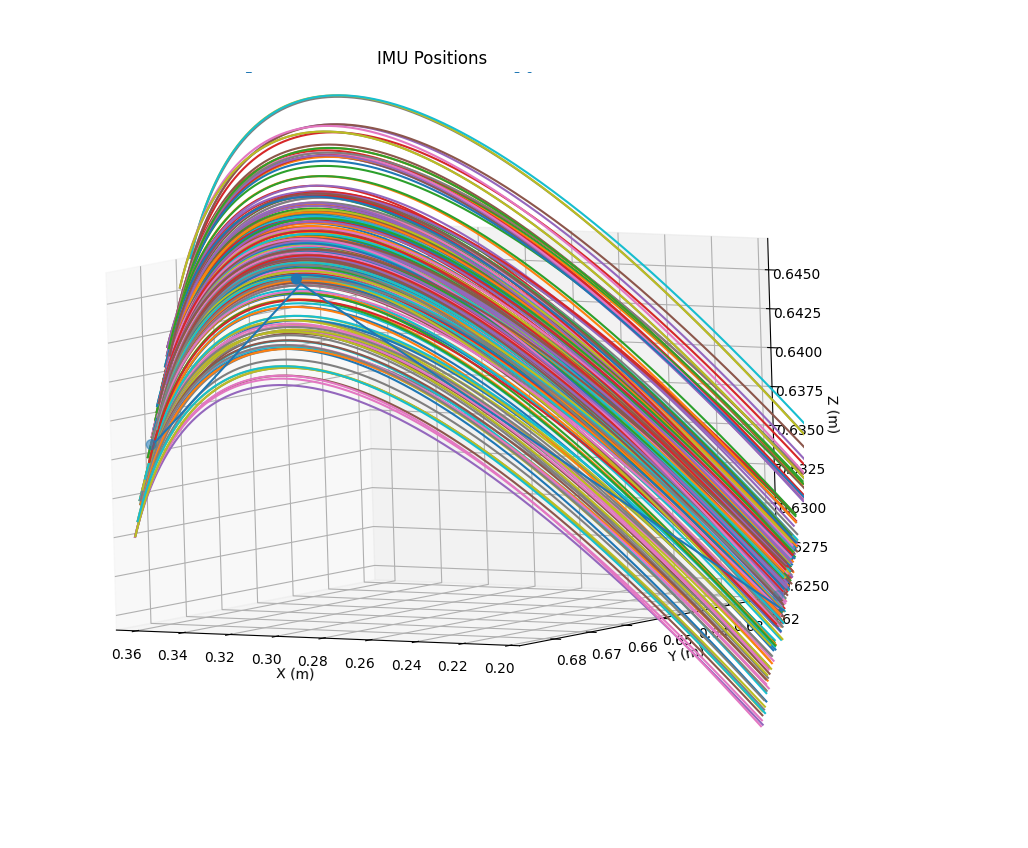

**Above**: There was basical interpolation across all points but an issue arose where these points weren't clearing with the next plot. Rather than the line function I am returning, I will return the cubic spline part. Only issue is that this current system is not robust at all and trying to find specific points on the global function will mean 